# Cat vs dog detector using TFLite

Uses transfer learning to train final layer in MobileNetv2 to detect classify cats and dogs. Once trained, the model is exported and run using TFLite.

## Gather dataset

In [1]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

def format_image(image, label):
    return tf.image.resize(image, (224, 224)) / 255.0, label

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
print("No. examples", num_examples, "No. classes", num_classes)

batch_size = 32
train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = raw_validation.map(format_image).batch(batch_size).prefetch(1)
test_batches = raw_test.map(format_image).batch(1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /Users/lukehutton/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
No. examples 23262 No. classes 2


## Download and train
Download the pre-trained MobileNetv2 model from TensorflowHub.

In [3]:
name, input_shape, output_shape = 'mobilenet_v2', (224, 224, 3), (1280,)
model_handle = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(name)

feature_extractor = hub.KerasLayer(model_handle,
                                   input_shape=input_shape,
                                   output_shape=output_shape,
                                   trainable=False)

model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.summary()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 5
model.fit(train_batches,
          epochs=epochs,
          validation_data=validation_batches)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/5
582/582 [==============================] - 372s 620ms/step - loss: 0.0528 - accuracy: 0.9821 - val_loss: 0.0394 - val_accuracy: 0.9862
Epoch 2/5
582/582 [==============================] - 368s 623ms/step - loss: 0.0302 - accuracy: 0.9896 - val_loss: 0.0432 - val_accuracy: 0.9845
Epoch 3/5
582/582 [==============================] - 2326s 4s/step - loss: 0.0251 - accuracy: 0.9915 - val_loss: 0.0415 - val_accuracy: 0.9875
Epoch 4/5
582/582 [==============================] - 386s 651ms/step 

## Save model
Save model as TensorFlow model.

In [4]:
saved_model = 'exp_saved_model'
tf.saved_model.save(model, saved_model)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: exp_saved_model/assets


INFO:tensorflow:Assets written to: exp_saved_model/assets


## Convert to TFLite model

In [11]:
import pathlib
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model)
tflite_model = converter.convert()
tflite_models_dir = pathlib.Path('/tmp/')
tflite_model_file = tflite_models_dir/'model1.tflite'
tflite_model_file.write_bytes(tflite_model)

8878832

## Run TFLite model

In [14]:
from tqdm import tqdm
tflite_model_file = '/tmp/model1.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']
predictions = []

test_labels, test_images = [], []
for img, label in tqdm(test_batches.take(100)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_images.append(img)
    
score = 0
for item in range(0, len(predictions)):
    prediction = np.argmax(predictions[item])
    label = test_labels[item]
    if prediction == label:
        score += 1
        
print(score, 'out of 100 predictions correct')

100%|██████████| 100/100 [00:02<00:00, 46.53it/s]

100 out of 100 predictions correct


## Visualise output

In [19]:
class_names = ['cat', 'dog']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = np.squeeze(img)
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    color = 'green' if predicted_label == true_label else 'red'
    plt.xlabel(f'prediction = {class_names[predicted_label]} \
               certainty = {100*np.max(predictions_array)} \
               (true = {class_names[true_label]})', color=color)
        

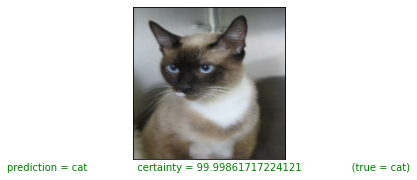

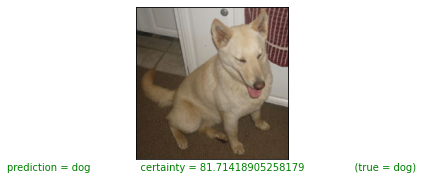

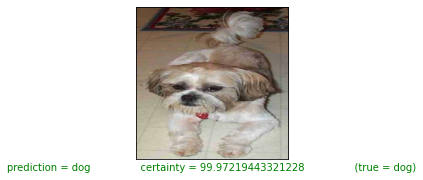

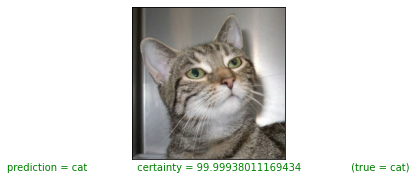

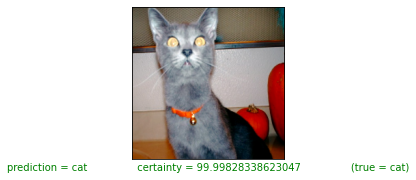

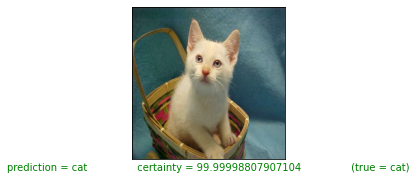

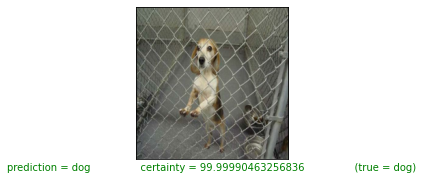

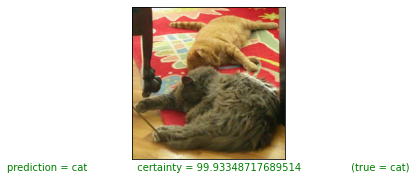

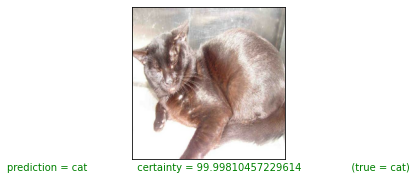

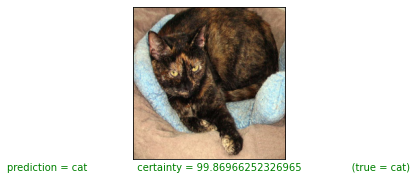

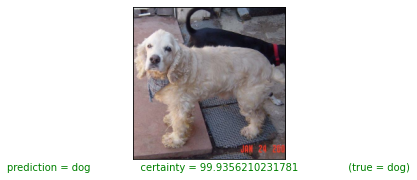

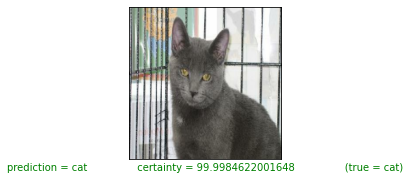

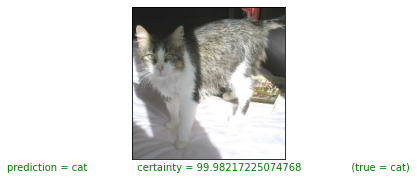

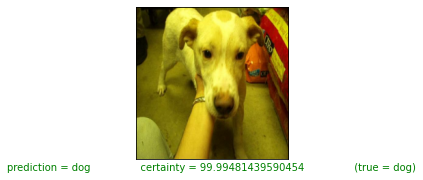

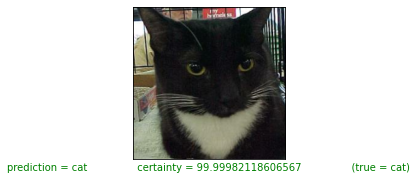

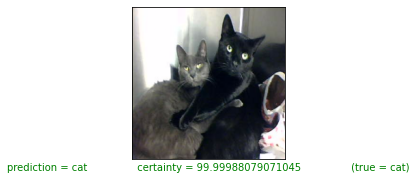

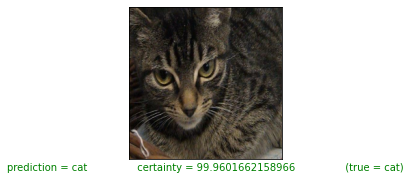

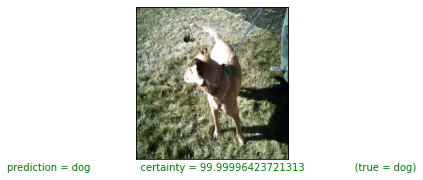

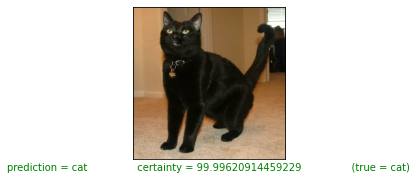

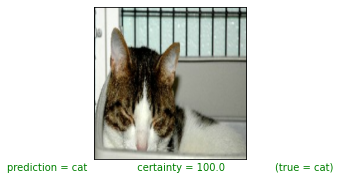

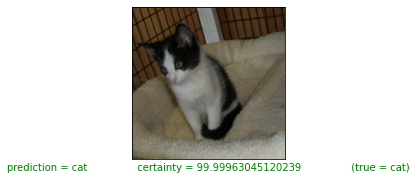

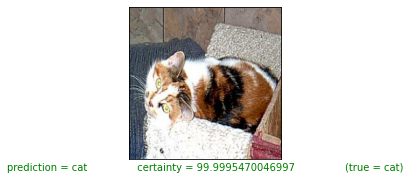

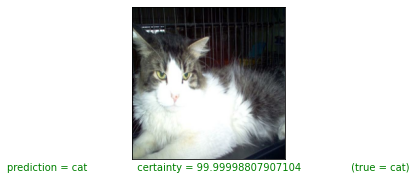

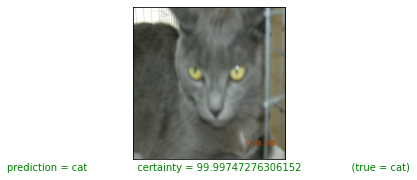

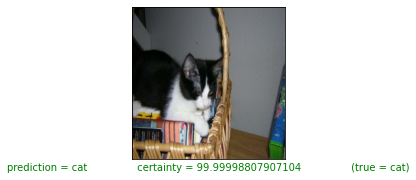

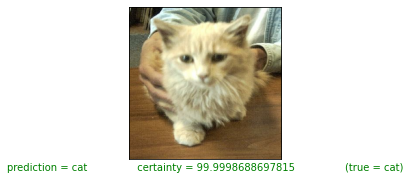

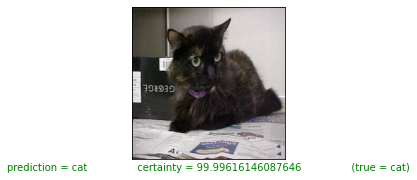

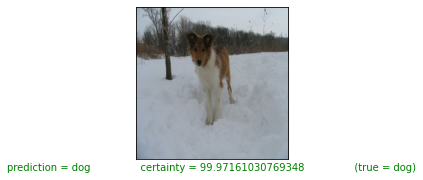

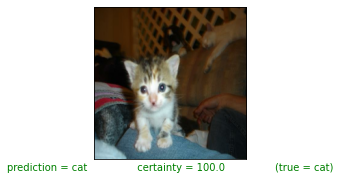

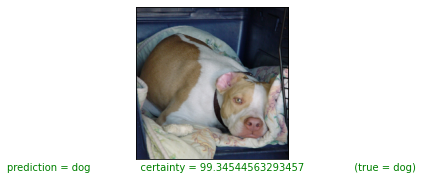

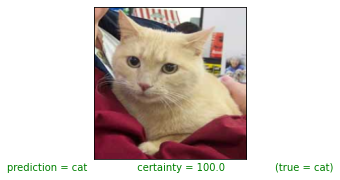

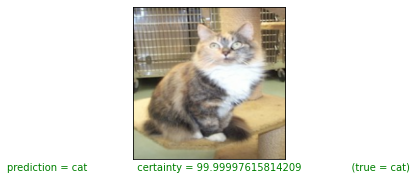

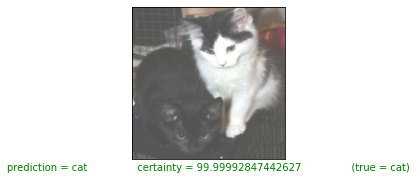

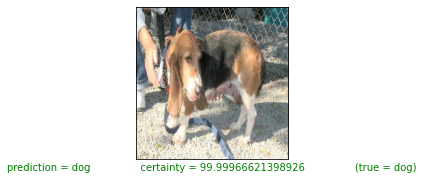

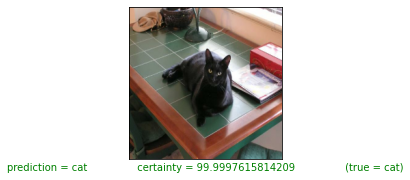

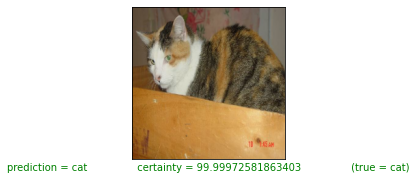

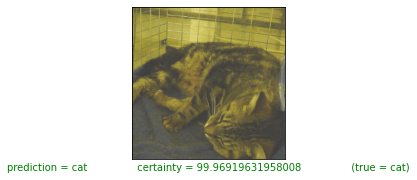

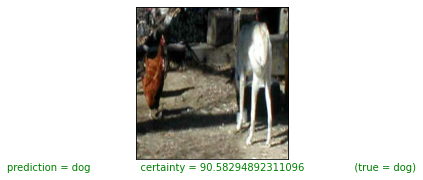

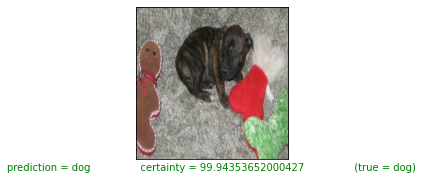

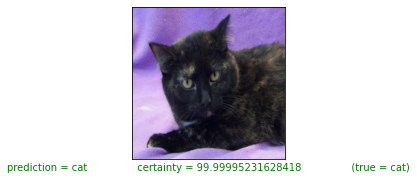

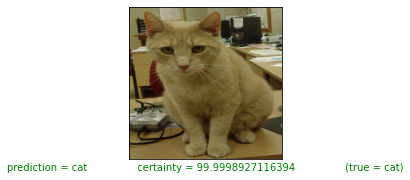

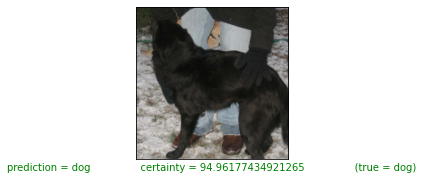

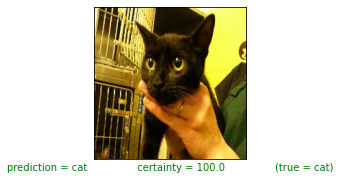

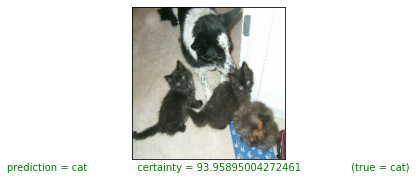

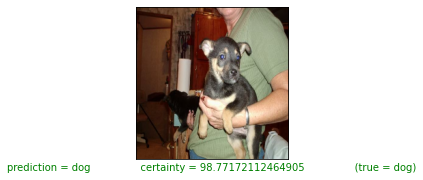

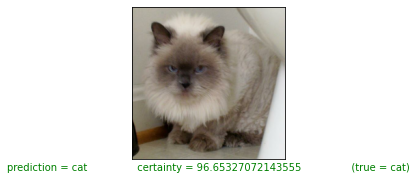

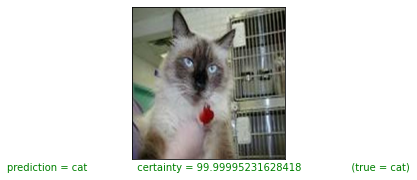

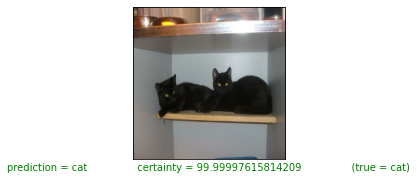

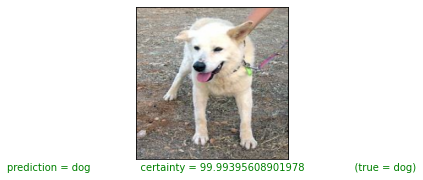

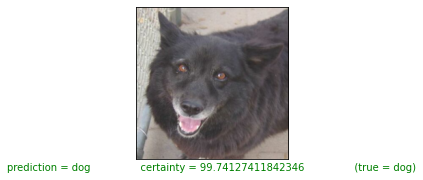

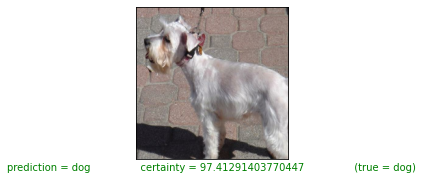

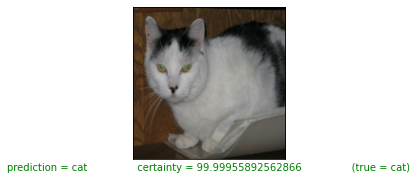

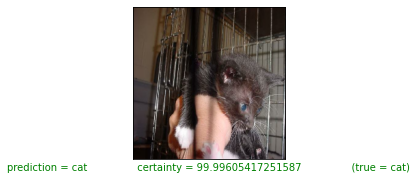

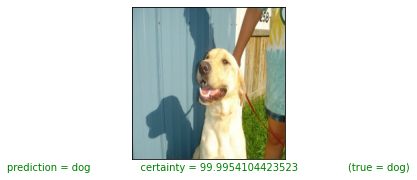

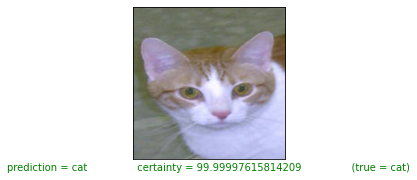

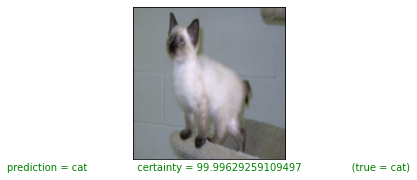

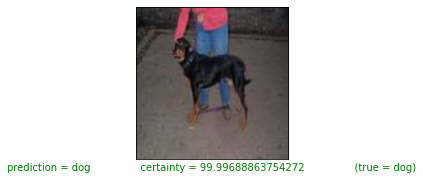

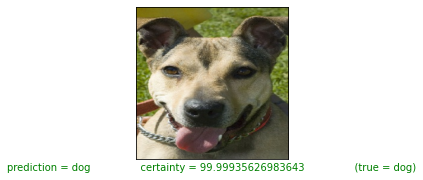

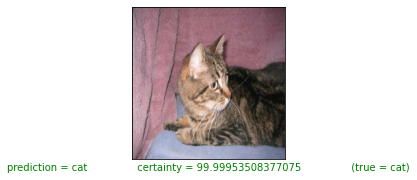

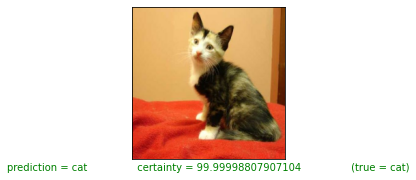

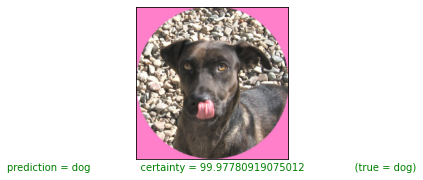

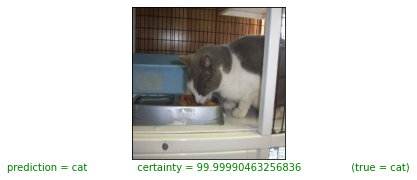

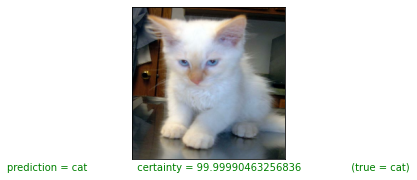

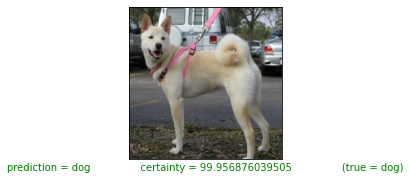

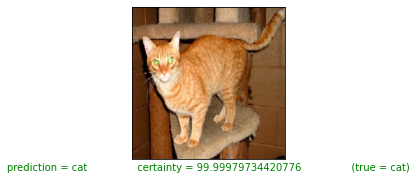

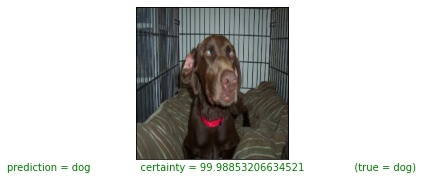

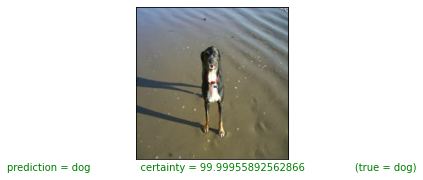

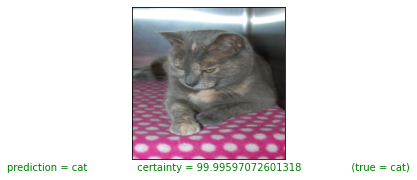

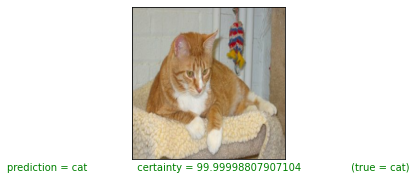

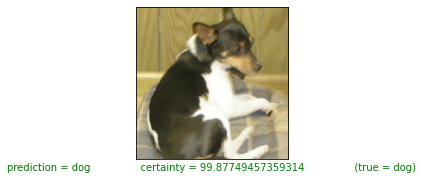

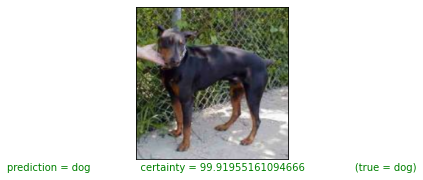

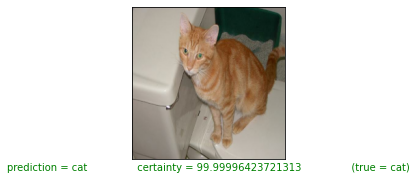

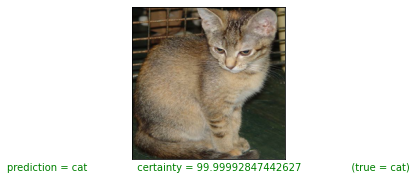

In [20]:
max_index = 73
for index in range(max_index):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plot_image(index, predictions, test_labels, test_images)
    plt.show()